<img src="https://github.com/sobester/ADRpy/raw/master/docs/ADRpy/ADRpy_splash.png" width="30%" align="left">

*Given a general layout (perhaps one of several candidates at this stage) and some idea of the maximum take-off weight, the next major step of the conceptual design process is the constraint analysis, which will yield the required wing area and thrust - effectively giving 'scale' to the concept.*

*The constraint analysis establishes the boundaries of the feasible part of the thrust to weight ratio (T/W) versus wing loading (W/S) space. Each element of the mission of the aircraft 'bites out' a chunk from this space and the aeroplane we progress to the subsequent stages of the design process will have to 'live' in the remaining subspace - generally at the lowest thrust/smallest wing point of the remaining feasible chunk.*

*This notebook is designed to walk the reader through ADRpy's constraint analysis capabilities in the context of an example, that of a single engine, piston-driven propeller aircraft.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ADRpy import unitconversions as co
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at

# Constraint Analysis of the Cirrus SR22

The Cirrus SR22 is a single engine, piston driven propeller aircraft.
To analyse a concept aircraft based on the SR22, we extract performance data from [1] and [2].

## Defining the Aircraft Concept

*For brevity, some user-definable parameters have been omitted - but a full list of parameters is available in the class documentation for `AircraftConcept`.*

We begin by creating a dictionary variable containing elements of the design brief.

Each row refers to a specific constraint: take-off, turn, climb, cruise, service ceiling, and stall.
All constraints are given for the clean configuration (no flaps/slats) apart from the take-off constraint.


In [2]:
# Extracted from [1]
nturn = 1 / np.cos(np.radians(60))  # Approx. load factor for 60 degrees of bank

designbrief = {
    "rwyelevation_m": 0.0, "groundrun_m": co.feet2m(1_082),           # Take-off
    "turnalt_m": 0, "turnspeed_ktas": 101, "stloadfactor": nturn,  # Sustained turn
    "climbalt_m": 0, "climbspeed_kias": 108, 'climbrate_fpm': 1_251,  # Climb
    "cruisealt_m": co.feet2m(10e3), "cruisespeed_ktas": 182,          # Cruise
    "servceil_m": co.feet2m(20_125), "secclimbspd_kias": 95,          # Service Ceiling
    "vstallclean_kcas": 73                                            # Stall
}
# The service ceiling constraint was found by linearly extrapolating data in the POH

Next, we describe the aircraft concept itself.
Geometry definitions are given at a very high level, along with an initial estimate for aircraft maximum take-off weight (MTOW).

Not all constraints of the aircraft have to be satisfied at MTOW, in which case we can also specify `"weightfractions"` for any of `"take-off"`, `"turn"`, `"climb"`, `"cruise"`, and `"servceil"` (service ceiling).

In [3]:
# Extracted from [2]
designdefinition = {
    "aspectratio": 10.12, "taperratio": 0.5,    # Wing "slenderness"
    "weight_n": co.lbf2n(3400),                 # Weight estimate
    "weightfractions": {"cruise": 3400 / 3600}  # Weight fractions
}

Now we define some performance estimates.
In some cases, users will have to estimate values from historical precedent of similar class or type aircraft.

In this case, the performance parameters are readily available from [2].

In [4]:
# Extracted from [2]
designperformance = {
    "CDmin": 0.02541, "CLmax": 1.41, "CLminD": 0.20, "CL0": 0.0,  # General performance
    "mu_R": 0.04, "CLTO": 0.590, "CDTO": 0.0414, "CLmaxTO": 1.69  # Take-off specific performance
}

All of the constraints have been defined under ISA standard day conditions.
For this reason, we initialise an object of the `Atmosphere` class to enable our constraint analysis.

In [5]:
designatm = at.Atmosphere()

And finally, to inform the constraint methods of how to normalise thrust and/or power estimates to sea-level static, it is necessary to specify the type of propulsion system.

In [6]:
designpropulsion = "Piston"

Having defined each of the aircraft concept's design brief,  definition, performance, atmopshere, and propulsion system attributes, we are ready to build our `AircraftConcept`:

In [7]:
concept = ca.AircraftConcept(
    brief=designbrief,
    design=designdefinition,
    performance=designperformance,
    atmosphere=designatm,
    propulsion=designpropulsion
)

## Plotting a Constraint Diagram

### Default Visualisation

Here is how to get a quick, clean result:
1. Define a monotonic range of wing loadings (in Pascal).
2. Call the `AircraftConcept.plot_constraints` method.

Depending on the concept's design attributes, the design space will be presented with any of the following
- x-axis: Wing area or Wing loading
- y-axis: Thrust/Weight, Thrust, Power/Weight, or Power

The plotting method intelligently recognises that a propeller based propulsion system would rather present to the user a metric related to power (as opposed to thrust), and since a MTOW was specified, P/W is automatically 'dimensionalised' as the required shaftpower.

See below...

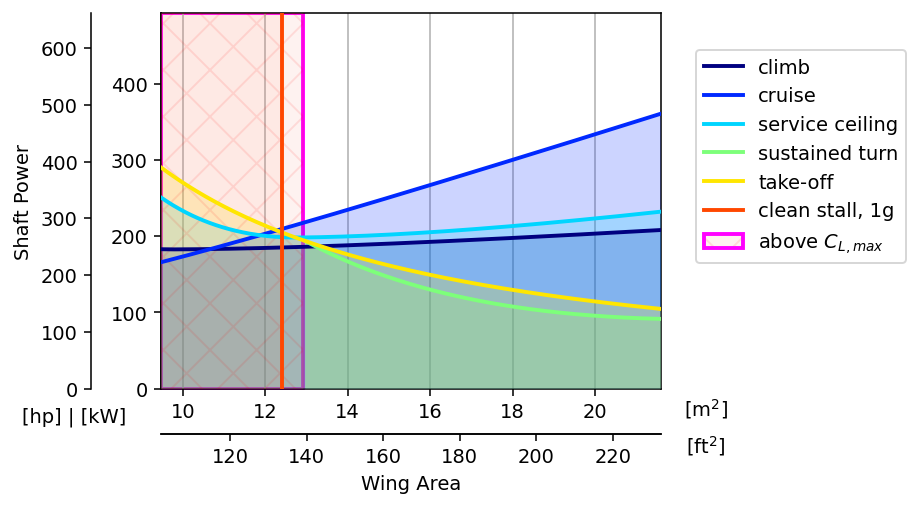

In [8]:
# Create a figure that shows off the constraints
ws_pa = np.arange(700, 1600, 5)         # Step 1
_, _ = concept.plot_constraints(ws_pa)  # Step 2

The unshaded region indicates the feasible design space.
The large, cross-hatched region indicates that one or more constraints cannot be satisfied by selecting a design in this space due to the maximum allowable $C_L$ being exceeded.

### Customising the Default Plot

We can further constrain the design space by applying a limit to the available shaftpower.
At the conceptual stage this may come from a general idea of the spread of power ratings across aircraft of similar types, or the known availability in a number of *off-the-shelf* solutions from engine manufacturers.
In this case we know for example, that the Cirrus SR22 uses a *Teledyne Continental IO-550-N*, rated for 310 horsepower in standard, sea-level conditions.

In [9]:
ratedpower_w = co.hp2w(310)

The `plot_constraints` methods returns both the matplotlib `Figure` and `Axes` objects used to draw the diagram.

Since these objects are available to you as an end-user, you can interact with and adjust their contents to your heart's content - which includes adding markers, modifying the legend, adding new constraints, and more.
In this case, we will add a constraint based on the rated engine power.
It's worth noting that the `Axes` object is always constructed with SI base units such as `[N]`, `[m/s]`, `[%]`, `[Pa]`, or `[W]`, and so any additions to the diagram should use these same unit scales.

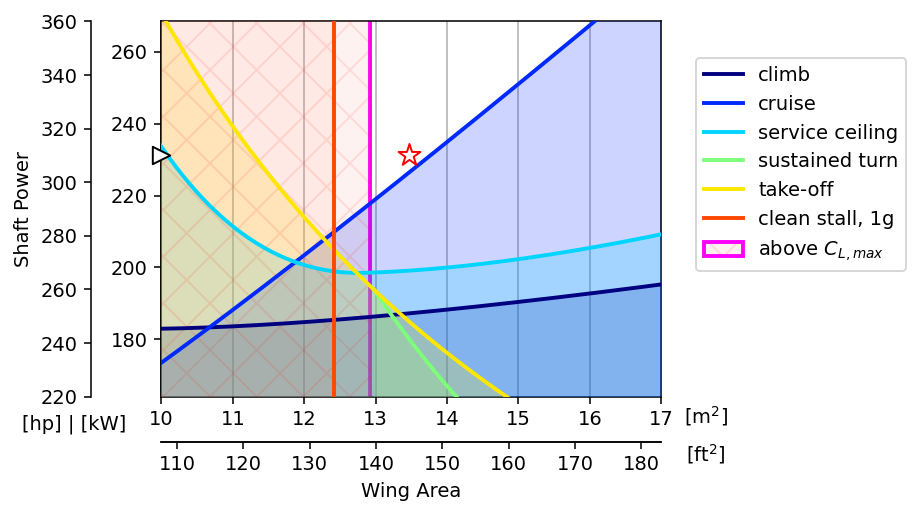

In [10]:
fig, ax = concept.plot_constraints(ws_pa)  # Make a fresh plot

# Optionally: Zoom in so we can see the constraint up close
# Do this now, otherwise our use of clip_on=False will cause markers to plot incorrectly later
ax.set_xlim(10, 17)
ax.set_ylim(co.hp2w(220), co.hp2w(360))

xaxis_limit_l, _ = ax.get_xlim()   # Left (and right) values of the plot's x-axis limits
designarea_m2 = co.feet22m2(145)  # We happen to know the design wing area of the SR22

# Using clip_on=False lets us put markers anywhere in the figure, including outside the plot area
common = {"fc": "white", "clip_on": False, "zorder": 100}
ax.scatter(xaxis_limit_l, ratedpower_w, marker=">", ec="k", s=80, label="IO-550-N power", **common)
ax.scatter(designarea_m2, ratedpower_w, marker="*", ec="r", s=140, label="SR22 design", **common)

ax.remake_legend();  # Refresh the legend with this custom method

According to the constraint analysis, a 295 hp engine will meet the requirements laid out by the design brief for the SR22.
This falls a little short of the actual aircraft's rated sea-level static power, which would suggest one or more of the following:
1. ... the SR22 has an oversize wing and engine.
2. ... our computational analysis of the constraints is flawed.
3. ... we have not considered all the factors.

One possible explanation is that the SR22 was certified for flight in the year 2000; this would to a development process that likely decided on Continental's latest engine: The IO-550-N (certified in 1996).
The IO-550-L (1988) and IO-550-E (1989) preceded the N-variant, but produced only 300 hp and were heavier at about +4 and +9 kg, respectively.

### A more flexible approach to plotting

The method demonstrated above creates a quick constraint diagram, but what if the engineer wishes to present the constraints in a different way, or perhaps, add additional constraints (e.g. constraints computed at different altitudes, weights, etc.)?

The solution is to 'unwrap' the constraint calculations:

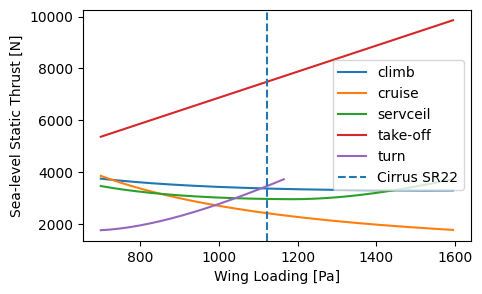

In [11]:
# Desired functions:labels to constrain
constraintfunctions = {
    "climb": lambda ac_obj: ac_obj.constrain_climb,
    "cruise": lambda ac_obj: ac_obj.constrain_cruise,
    "servceil": lambda ac_obj: ac_obj.constrain_servceil,
    "take-off": lambda ac_obj: ac_obj.constrain_takeoff,
    "turn": lambda ac_obj: ac_obj.constrain_turn
}

# Create plot data
tw_reqs, pw_reqs = dict(), dict()

for label, func in constraintfunctions.items():
    tw_reqs[label], pw_reqs[label] = func(ac_obj=concept)(ws_pa)

# Plot!
fig, ax = plt.subplots(figsize=(5, 3))

for name, tw in tw_reqs.items():
    ax.plot(ws_pa, tw * concept.design.weight_n, label=name)

concept_ws = concept.design.weight_n / designarea_m2
ax.axvline(concept_ws, ls="--", label="Cirrus SR22")

ax.set_xlabel("Wing Loading [Pa]")
ax.set_ylabel("Sea-level Static Thrust [N]")
ax.legend();

## Constraint Sensitivity Analysis

Thus far, we have shown how a concept definition can rapidly reveal the feasible design subspace.
What we have not seen, however, is how sensitive the shape and size of this space is to changes in any of the design variables.
To study this we can employ constraint *Sensitivity Analysis*, a technique for investigating the sensitivity of an output (the design) to changes in the input (high-level parameters we set in the concept definition).

For large, complex systems with many independent variables, a common approach is to carry out a *Monte Carlo simulation*.
Input values take random values from a given probability distribution.
It's up to us to select appropriate distributions for the inputs.

### Example - How Robust is the Concept?

To determine how robust a concept is to changes in the input design parameters, there are three things to consider for each parameter:
1. Do we need to investigate the sensitivity of this variable?
2. If yes, what distribution should we use?
3. ... and what is the magnitude of the distribution's uncertainty?

We start with the following distributions

In [12]:
# Number of Monte Carlo simulations to carry out
ndraws = 1_000

# Use NumPy distributions to draw random values
VC = np.random.uniform(178, 186, size=ndraws)
CLminD = np.random.normal(0.20, 0.05, size=ndraws)
ISAoffset = np.random.normal(0, 10, size=ndraws)
CDmin = np.random.normal(0.02541, 0.002, size=ndraws)

It's always a good idea when beginning a sensitivity analysis to ensure that you know your inputs are distributed as you expect, or else you may end up drawing spurious correlations or incorrect assertions from your results!

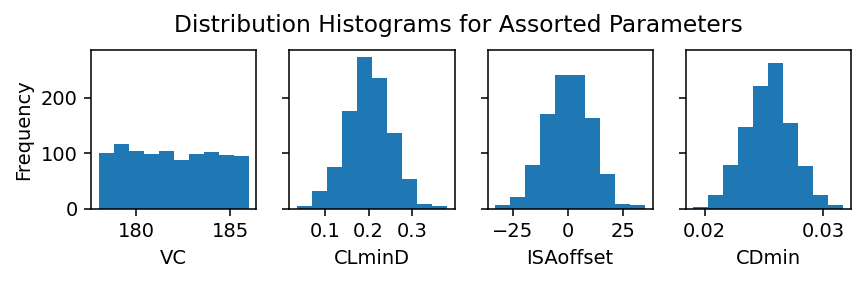

In [13]:
fig, axs = plt.subplots(1, 4, dpi=140, figsize=(7, 1.6), sharey=True)
fig.suptitle("Distribution Histograms for Assorted Parameters")
fig.subplots_adjust(top=0.82)
axs[0].set_ylabel("Frequency")

inputvars = {"VC": VC, "CLminD": CLminD, "ISAoffset": ISAoffset, "CDmin": CDmin}
for i, (label, data) in enumerate(inputvars.items()):
    axs[i].hist(data)
    axs[i].set_xlabel(label)

plt.show()

Now we can proceed with the analysis!
Let's setup a variable to store our output.

We'd like to store a number (`ndraws`) of power requirements for each of our wing loadings (`ws_pa`) in the original constraint analysis, so we'll use `np.zeros((*ws_pa.shape, ndraws))` to create a 2D array.
Of course we'd also like to do this for each of our constraint types, so let's use dictionary comprehension to create a 2D array for each constraint.

In [14]:
# A dictionary of power requirements for each constraint
Preqs = {
    name: np.zeros((*ws_pa.shape, ndraws))        # store a key/value pair
    for (name, _) in constraintfunctions.items()  # ... for each key in this other dictionary
}

Run the simulation...

In [15]:
# Run ndraws number of simulations
for i in range(ndraws):
    
    # Use more dictionary comprehension to create new concept design dictionaries.
    # Using:
    #     new_dict = {**defaults_dict, "key2update": shiny_new_value, ...}
    #
    mc_designbrief = {**designbrief, "cruisespeed_ktas": VC[i]}
    mc_designperformance = {**designperformance, "CDmin": CDmin[i], "CLminD": CLminD[i]}
    
    # Slightly different approach for modifying the atmosphere
    mc_designatm = at.Atmosphere(offset_deg=ISAoffset[i])
    
    # Create our Monte Carlo concept for the i'th time
    mc_concept = ca.AircraftConcept(
        brief=mc_designbrief,
        design=designdefinition,
        performance=mc_designperformance,
        atmosphere=mc_designatm,
        propulsion="Piston"
    )
    
    # For each constraint, compute P/W and then Power
    for label, func in constraintfunctions.items():
        _, mc_pw = func(ac_obj=mc_concept)(ws_pa)
        mc_p = mc_pw * mc_concept.design.weight_n
        
        # Store the computed power in our variable for capturing outputs.
        # e.g.
        #    Preqs["cruise"][:, 62] = mc_p 
        #
        # ... is storing the power computed for each wing loading (dimension 0 --> [:,   ])
        # and we are currently on the 63rd computation            (dimension 1 --> [ , 62])
        Preqs[label][:, i] = mc_p


Display the results of the simulation by recreating our constraints plot from earlier, but now with error bars

C:\Users\yr3g17\AppData\Local\Temp\ipykernel_20824\2515693791.py:9: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(Preqs[label], axis=-1)  # axis=-1, average result of the ndraws at each ws_pa
C:\Users\yr3g17\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


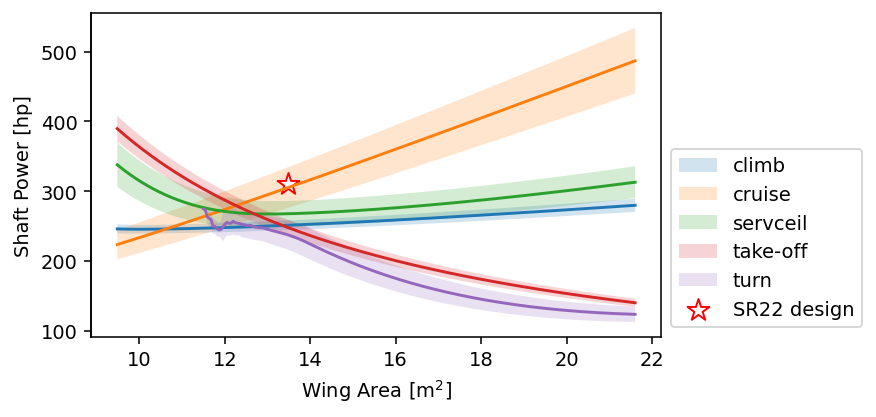

In [16]:
fig, ax = plt.subplots(dpi=140, figsize=(5.25, 3))

xdata = concept.design.weight_n / ws_pa  # get x-axis

# For each constraint in our output dictionary
for label, _ in Preqs.items():
    
    # Compute the mean and standard deviation
    mu = np.nanmean(Preqs[label], axis=-1)  # axis=-1, average result of the ndraws at each ws_pa
    sig = np.nanstd(Preqs[label], axis=-1, ddof=1)  # ddof=1, sample-corrected standard deviation
    
    # Plot a solid line for the mean, and a shaded region for the +/- 1 standard deviation
    l2d, = ax.plot(xdata, mu)
    ax.fill_between(xdata, mu+sig, mu-sig, label=label, alpha=0.2, fc=l2d.get_color())

# Turn the y-axis ticks displaying units of [W] invisible, and replace with units of [hp]
ax.set_yticks([])
secax_y = ax.secondary_yaxis("left", functions=(co.w2hp, co.hp2w))
secax_y.set_ylabel("Shaft Power [hp]")

# Other things to make the plot pretty
ax.set_xlabel("Wing Area [m$^2$]")
# ax.set_xlim(10, 17)
# ax.set_ylim(co.hp2w(240), co.hp2w(380))
ax.scatter(designarea_m2, ratedpower_w, marker="*", ec="r", fc="w", s=140, label="SR22 design")
ax.legend(loc="lower left", bbox_to_anchor=(1, 0));

Evidently, the simulation is struggling to compute feasible solutions to the turn constraint in the region we had previously identified as exceeding the maximum allowable $C_L$.

On another note, it appears that the constraint subject to the greatest variability in our Monte Carlo simulation is that relating to the cruise condition.
Can we do anything to quantify and/or mitigate this?

### Example - Uncertainty Propagation through the Cruise Constraint

Rather than plotting the change in power requirement as a function of wing area, we can simply plot the power requirement as a function of the parameter to investigate.

Recall in the previous example, we computed and stored a two-dimensional array of power requirements for each constraint, where the array had shape `(<shape-of-wing-loading-array>, ndraws)`.
We took the mean and standard deviation along `axis=-1` for each constraint, which meant taking the mean and standard deviation of the power requirement over all our `ndraws` at each wing loading.
That left us with a *wing-loading-sized-array* of averages and standard deviations (which we could then plot against `ws_pa`).

Since every individual draw of `ndraws` *should* be a random, unique aircraft - consolidating results in the wing loading axis of our 2D results array should give us an estimate of each drawn aircraft's performance.

That means this time, we use `axis=0` to get the power requirement averaged across all of the wing loadings for each of our `ndraws` Monte Carlo iterations (leaving us with `ndraws` sized arrays of averages and standard deviations).

Now that we have an estimate for the power requirement of each random aircraft, and because our input values have the same index `i` in `range(ndraws)` as our resultant power requirement arrays, we can scatter plot the inputs and output to investigate correlation between the two.

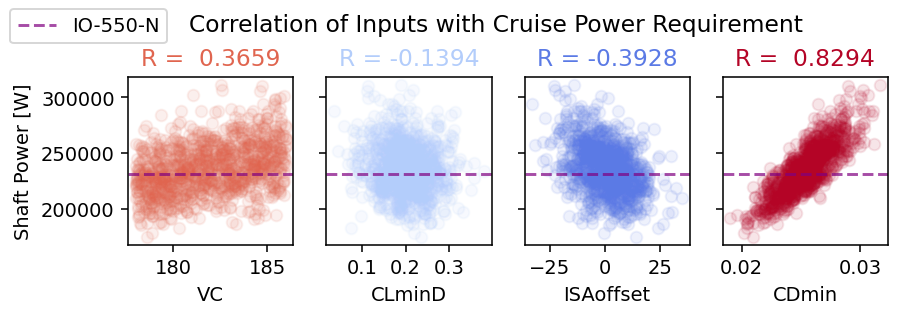

In [17]:
fig, axs = plt.subplots(1, 4, dpi=140, figsize=(7, 1.9), sharey=True)
fig.suptitle("Correlation of Inputs with Cruise Power Requirement")
fig.subplots_adjust(top=0.74)
axs[0].set_ylabel("Shaft Power [W]")

# Here's where we use axis=0 instead of axis=-1
cruisepower_w = np.nanmean(Preqs["cruise"], axis=0)

plot_kwargs = {"alpha":0.1}
cmap = plt.get_cmap("coolwarm")
for i, (label, xdata) in enumerate(inputvars.items()):
    
    # Compute Pearson product-moment correlation coefficients
    R = np.corrcoef(xdata, cruisepower_w)[0][-1]
    axs[i].set_title(f"R = {R: .4f}", color=cmap(R+0.5))
    
    axs[i].axhline(ratedpower_w, ls="--", c="purple", alpha=0.7, label="IO-550-N")
    axs[i].scatter(xdata, cruisepower_w, **plot_kwargs, color=cmap(R+0.5))
    axs[i].set_xlabel(label)

else:
    # Squash keys in a legend so we don't have any duplicates
    handles, labels = axs[i].get_legend_handles_labels()
    fig.legend(handles=handles, labels=labels, loc="upper left")

For each variable we have computed the *Pearson product-moment correlation coefficient*, $R$, to determine the strength of the correlation between the input parameter and the computed shaft power.
The coefficient $R$ takes a value from -1 to 1, where each extreme describes a strong negative and a strong positive correlation, respectively.

Our choice of cruise speed was uniformly distributed about the actual design speed of the SR22.
It is weakly, but positively correlated with the sea-level static shaft power requirement.

We normally distributed the coefficient of lift at which drag is minimised, `CLminD`.
In this case, $R\approx0$ indicates a very weak relationship between `CLminD` and the required sea-level static shaft power for cruising.
Increasing the coefficient of lift at which minimum drag occurs should intuitively, reduce the drag force at cruise.

We normally distributed the `ISAoffset` $\pm10^\circ \text{C}$, which means that each constraint has some random probability of being evaluated at ambient conditions above or below ISA standard day.
A correlation coefficient of $|R|\sim0.4$ indicates a moderately strong relationship, and the minus sign indicates a negative correlation - i.e., an unusually warm atmosphere will drop the sea-level static normalised shaft power requirement.

Finally, `CDmin`'s $R\sim0.8$ indicates a very strong, high level of association between it and the shaft power requirement of the engine.
A greater minimum drag coefficient, intuitively, demands greater propulsive power.

To find out in what proportion of draws we actually satisfy the cruise constraint, we can move to quantify the uncertainty.

### Example - Uncertainty Quantification

By definition, 50% of the data should be found either side of the mean power requirement curve.
If we compute the perpendicular distance of the design point to this line, we can characterise this distance in terms of the likelihood of a concept overreaching this distance (and violating the constraint).

In [18]:
# First-order estimate of the (wingloading) array index that we are
# trying to match to shaft power
xdata = concept.design.weight_n / ws_pa  # get x-axis
designindex = np.argsort(np.abs(xdata-designarea_m2))[0]

def power_by_percentile(percentile):
    # Use axis=-1 to get the n'th percentile data at each loading ws_pa
    pct_cruisepowers = np.percentile(Preqs["cruise"], percentile, axis=-1)
    pct_cruisepower = pct_cruisepowers[designindex]
    return pct_cruisepower

for i in range(101):
    if power_by_percentile(i) <= ratedpower_w:
        continue
    print(f"Given uncertainty in the design, there is a ~{i}%", 
          f"chance of the cruise power requirement being met.")
    break

Given uncertainty in the design, there is a ~60% chance of the cruise power requirement being met.


# References
<a name="refs"></a>

[1] "Pilot's Operating Handbook and FAA Approved Airplane Flight Manual for the Cirrus SR22," Cirrus Design, 2013. Accessed: 25/12/2023. [Online]. Available: http://servicecenters.cirrusdesign.com/tech_pubs/SR2X/pdf/POH/SR22-004/pdf/Online13772-004.pdf.

[2]  Gudmundsson, S., "General Aviation Aircraft Design: Applied Methods and Procedures", Butterworth-Heinemann, 2013. 